In [1]:
import torch
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import confusion_matrix
import mplhep as hep
from models import GraphNet
plt.style.use(hep.style.CMS)

In [89]:
def plotTrackster2D(fig, ax2, y, z, heatmap=None, indexes=None, edges=None, edges_t = None, label='Trackster Energy (GeV)'):
    fs = 16
    for ind in edges:
        if(ind not in edges_t):
            if len(ind) == 0:
                continue
#             for ied in ind:
            idx0 = ind[0]
            idx1 = ind[1]
            ax2.plot(
                [y[idx0] ,y[idx1]],
                [z[idx0] ,z[idx1]],
                'red', lw = 0.5, label = "Wrong Edges"
            )
        else:
            if len(ind) == 0:
                continue
#             for ied in ind:
            idx0 = ind[0]
            idx1 = ind[1]
            ax2.plot(
                [y[idx0], y[idx1]],
                [z[idx0] ,z[idx1]],
                'black', lw = 0.5, label = "Correct Edges"
            )
    for t_ind in edges_t:
        if(t_ind not in edges):
            if len(ind) == 0:
                continue
#             for ied in ind:
            idx0 = ind[0]
            idx1 = ind[1]
            ax2.plot(
                [y[idx0] ,y[idx1]],
                [z[idx0] ,z[idx1]],
                'blue', lw = 0.5, label = "Missed Edges"
            )
    yg = ax2.scatter(y, z, c=cm.viridis(heatmap/max(heatmap)), marker='o', linewidth=2)
    ax2.tick_params(axis='x', labelsize=fs )
    ax2.tick_params(axis='y', labelsize=fs )

In [ ]:
    
    
def plotTrackster3D(fig, ax, x, y, z, heatmap=None, indexes=None, edges=None, edges_t = None, label='Trackster Energy (GeV)'):
    fs = 15
    print(x[0],y[0],z[0])
    ax.set_xlabel('Z (cm)', fontsize = fs)
    ax.set_ylabel('X (cm)', fontsize = fs)
    ax.set_zlabel('Y (cm)', fontsize = fs)
    colmap = cm.ScalarMappable(cmap=cm.viridis)
    if len(heatmap) > 0:
        for ind in edges:
            if(ind not in edges_t):
                if len(ind) == 0:
                    continue
    #             for ied in ind:
                idx0 = ind[0]
                idx1 = ind[1]
                ax.plot(
                    [x[idx0] ,x[idx1]],
                    [y[idx0] ,y[idx1]],
                    [z[idx0] ,z[idx1]],
                    'red', lw = 0.5, label = "Wrong Edges"
                )
            else:
                if len(ind) == 0:
                    continue
    #             for ied in ind:
                idx0 = ind[0]
                idx1 = ind[1]
                ax.plot(
                    [x[idx0] ,x[idx1]],
                    [y[idx0] ,y[idx1]],
                    [z[idx0] ,z[idx1]],
                    'black', lw = 0.5, label = "Correct Edges"
                )
        for t_ind in edges_t:
            if(t_ind not in edges):
                if len(ind) == 0:
                    continue
    #             for ied in ind:
                idx0 = ind[0]
                idx1 = ind[1]
                ax.plot(
                    [x[idx0] ,x[idx1]],
                    [y[idx0] ,y[idx1]],
                    [z[idx0] ,z[idx1]],
                    'blue', lw = 0.5, label = "Missed Edges"
                )
    if len(heatmap) > 0 :
        colmap.set_array(heatmap)
        yg = ax.scatter(x, y, z, c=cm.viridis(heatmap/max(heatmap)), marker='o', linewidth=2)
        cb = fig.colorbar(colmap,label=label)
    else:
        yg =ax.scatter(x, y, z, marker='o')     
    ax.tick_params(axis='x', labelsize=fs )
    ax.tick_params(axis='y', labelsize=fs )
    ax.tick_params(axis='z', labelsize=fs )



In [ ]:
from matplotlib.lines import Line2D
def plotTrackster(fig, ax,ax2,ax3,ax4, x, y, z, heatmap=None, indexes=None, edges=None, edges_t = None, label='Trackster Energy (GeV)'):
    plotTrackster3D(fig, ax, x,y,z, heatmap=E,edges=p_pairs, edges_t = t_pairs )
    ## XY
    plotTrackster2D(fig, ax2 ,y, z,heatmap=E,edges=p_pairs, edges_t = t_pairs)
    ## XZ
    plotTrackster2D(fig, ax3 ,y, x,heatmap=E,edges=p_pairs, edges_t = t_pairs)
    ##YZ
    plotTrackster2D(fig, ax4 ,z, x,heatmap=E,edges=p_pairs, edges_t = t_pairs)
    custom_lines = [Line2D([0], [0], color='red',lw = 4),
                    Line2D([0], [0], color='black', lw=4),
                   Line2D([0], [0], color='blue', lw=4)]
    ax.legend(custom_lines, ['Wrong Edges', 'Correct Edges', "Missed Edges"])

    plt.show()

In [ ]:
def truth_pairs(model, data_list, ev, thr):
    data_list_ev = data_list[ev]
    truth_edge_index = data_list_ev.edge_index
    truth_edge_label = data_list_ev.edge_label > thr
    truth_nodes_features = data_list_ev.x
    
    src_edge_index_true = truth_edge_index[0][truth_edge_label]
    dest_edge_index_true = truth_edge_index[1][truth_edge_label]
    src_truth_barycenter = truth_nodes_features[src_edge_index_true][:,2:5]
    dest_truth_barycenter = truth_nodes_features[dest_edge_index_true][:,2:5]
    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i], dest_edge_index_true[i]])
    return truth_nodes_features, index_tuple

def prediction_pairs(model, data_list, ev, thr = 0.5):
    data_list_ev = data_list[ev]
    out = model(data_list_ev)
    truth_edge_index = data_list_ev.edge_index
    truth_edge_label = out > thr
    truth_nodes_features = data_list_ev.x
    src_edge_index_true = truth_edge_index[0][truth_edge_label]
    dest_edge_index_true = truth_edge_index[1][truth_edge_label]
    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i], dest_edge_index_true[i]])

    src_truth_barycenter = truth_nodes_features[src_edge_index_true][:,2:5]
    dest_truth_barycenter = truth_nodes_features[dest_edge_index_true][:,2:5]
    
    return truth_nodes_features,index_tuple 
    

In [90]:
# Load data
path_data = '/afs/cern.ch/user/a/abhiriks/public'
with open("{}/node_features".format(path_data), "rb") as fp:
    X = pickle.load(fp)
    
with open("{}/edges".format(path_data), "rb") as fp:
    Edges = pickle.load(fp)
    
with open("{}/edges_labels".format(path_data), "rb") as fp:
    Edge_labels = pickle.load(fp)

In [91]:
# process data
edge_data = []
edge_label = []
node_data = []
for ev in range(len(X)):
    if len(Edges[ev]) == 0:
        print(f"event {ev} edges {Edges[ev]}")
        continue # skip events with no edges
    else:
        X_ev = []
        edge_data.append(Edges[ev])
        edge_label.append([np.float32(edg) for edg in Edge_labels[ev]])
        for field in X[ev].fields:
            X_ev.append(ak.to_numpy(X[ev][field]))
        node_data.append(X_ev)

event 151 edges []


In [92]:
data_list = []
for ev in range(len(node_data)):
    x = torch.from_numpy(np.array(node_data[ev]).T)
    e_label = torch.from_numpy(np.array(edge_label[ev]))
    edge_index = torch.from_numpy(edge_data[ev])
    data = Data(x=x, num_nodes=torch.tensor(x.shape[0]), edge_index=edge_index, edge_label=e_label)
    data_list.append(data)

In [93]:
# split into train, val, test sets
trainRatio = 0.8
valRatio = 0.1
testRatio = 0.1

nSamples = len(data_list)

nTrain = int( trainRatio * nSamples  )
nVal = int( valRatio * nSamples )

trainDataset = data_list[:nTrain]           # training dataset
valDataset = data_list[nTrain:nTrain+nVal]  # validation dataset
testDataset = data_list[nTrain+nVal:]       # test dataset

In [94]:
testLoad = DataLoader(testDataset, batch_size=1)

In [95]:
test = testLoad.dataset[0]

In [96]:
modelLoad = GraphNet()
modelLoad.load_state_dict(torch.load("./TESTMODEL.pt"))

<All keys matched successfully>

In [97]:
outTest = modelLoad(test)

In [99]:
ev_vis = 18 #event to visualize
t_node, t_pairs = truth_pairs(modelLoad, testDataset, ev_vis, 0.5)
p_node, p_pairs = prediction_pairs(modelLoad, testDataset, ev_vis, 0.6)

tensor([0.5340, 0.5661, 0.5563, 0.5892, 0.5913, 0.5775, 0.5814, 0.5696, 0.5778,
        0.5909, 0.6082, 0.5968, 0.5871, 0.6518, 0.6537, 0.6408, 0.6316, 0.6636,
        0.6755, 0.5826, 0.5933, 0.6664, 0.6683, 0.6557, 0.6466, 0.6780, 0.7108,
        0.7036, 0.6896, 0.7422, 0.7439, 0.7329, 0.7813, 0.7251, 0.7419, 0.7521,
        0.7798, 0.7738, 0.7620, 0.8166, 0.7392, 0.7408, 0.7298, 0.7786, 0.7219,
        0.7388, 0.7491, 0.7771, 0.7710, 0.7591, 0.6515, 0.6535, 0.6405, 0.6313,
        0.6633, 0.6969, 0.6752, 0.8016, 0.7200, 0.7217, 0.7833, 0.7838, 0.7102,
        0.7614, 0.7019, 0.7304, 0.7598, 0.7534, 0.7409, 0.6765, 0.5931, 0.6200,
        0.6369, 0.6494, 0.6837, 0.6762, 0.6397, 0.7307, 0.7909, 0.7914, 0.7756,
        0.7194, 0.7695, 0.7113, 0.7286, 0.7392, 0.7679, 0.7617, 0.7495, 0.7959,
        0.7310, 0.7526, 0.7332, 0.7773, 0.6896, 0.6914, 0.7581, 0.6792, 0.7338,
        0.6892, 0.7007, 0.7321, 0.7252, 0.6911, 0.7572, 0.7577, 0.6788, 0.7335,
        0.6701, 0.7003, 0.7317, 0.7249, 

In [100]:
from pylab import cm
from IPython.display import display

331.24036 70.19722 -45.312584


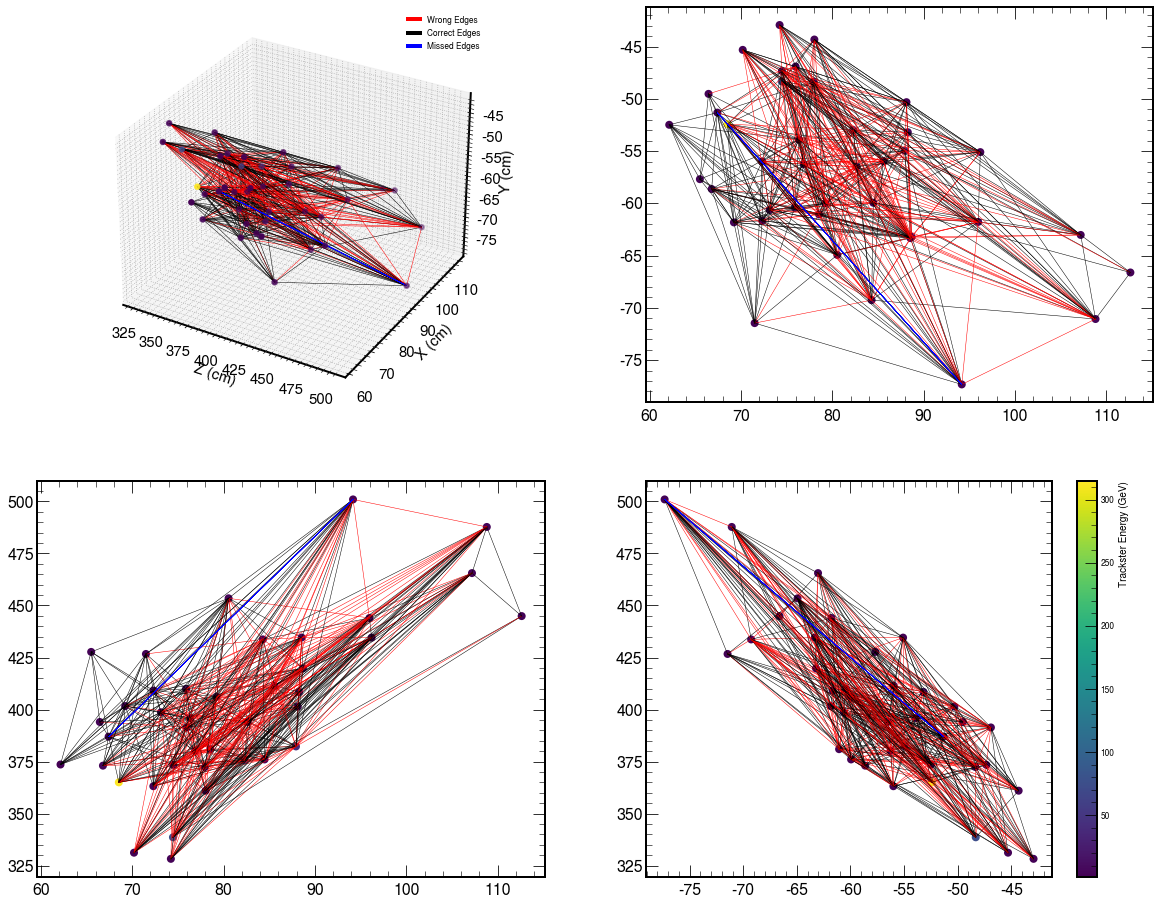

In [101]:
%matplotlib inline
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
x = p_node[:,2].detach().numpy()
y = p_node[:,3].detach().numpy()
z = p_node[:,4].detach().numpy()
E = p_node[:,0].detach().numpy()
plotTrackster(fig, ax, ax2,ax3,ax4, z,x,y,heatmap=E,edges=p_pairs, edges_t = t_pairs)